# 2D Ising model phase classification by NN
## 1. Generate 2D Ising model configuration by Metropolis algorithm:
1. Prepare an initial configuration of N spins
2. Flip the spin of a randomly chosen lattice site.
3. Calculate the change in energy dE.
4. If dE<0, accept the move. Otherwise accept the move with probability exp(-dE/T). This satisfies the detailed balance condition, ensuring a final equilibrium state.
5. repeat 2-4.
# Hamiltonian of 2D Ising model

$$H = -\Sigma_{i,j} S_i S_j$$



In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

C:\Users\CY.Liu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define functions:
### 1. initialstate(N):
    prepare a random state for future flippling process.
### 2. mcmove(config, beta):
    input a configuration (for 1st move, generated by initialstate(N)) 
    and return a flipped configuration that the flipping process is 
    depend on the temperature of the system (parameter beta)
### 3. calcEnergy(config):
    Calculate the energe of given configuration.
### 4. calcMag(config):
    Calculate the magnetization of given configuration.
 

In [2]:
#generate a random spin configuration for initial condition
def initialstate(N):
    state = 2*np.random.randint(2, size = (N, N)) - 1
    state = state.astype(float)
    return state

#Monte Carlo move using Metropolis algorithm
def mcmove(config, beta):
    for i in range(N):
        for j in range(N):
            a = np.random.randint(0, N) # a random integer in range(N)
            b = np.random.randint(0, N)
            s = config[a, b] # choose some configuration 
            
            nb = (              #possible value: int in -4~+4
              config[(a+1)%N,b]
            + config[a,(b+1)%N] 
            + config[(a-1)%N,b] 
            + config[a,(b-1)%N]
                 )
            cost = 2*s*nb #\Sigma_{ij} S_i S_j
            if cost < 0:
                s*=-1
            elif rand() < np.exp(-cost*beta):
                s*=-1
            config[a,b] = s
    
    return config
    
#Energy of a given configuration
def calcEnergy(config):
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            #hoping in (up, down, left, right) direction
            nb = (
             config[(i+1)%N, j]
            +config[i, (j+1)%N]
            +config[(i-1)%N, j]
            +config[i, (j-1)%N]
            )
            energy += -nb*S 
       
    return energy/4. #(算到上下左右四個，要除掉)
    
#Magnetization of a given configuration
def calcMag(config):
    mag = np.sum(config)
    return mag 

## Parameters

In [3]:
nt      = 50         #  number of temperature points
N       = 4         #  size of the lattice, N x N
eqSteps = 200       #  number of MC sweeps for equilibration
mcSteps = 200      #  number of MC sweeps for calculation

T       = np.linspace(1.53, 3.28, nt); 
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

SpinConfiguration = []
Mg = []

In [4]:
for tt in range(nt):
    SC1 = []
    mag1 = []
    config = initialstate(N)
    iT=1.0/T[tt]; #inverse T = 1/T
    iT2=iT*iT; #inverse T^2 = 1/T^2
    
    for i in range(eqSteps):         # equilibrate first
        mcmove(config, iT)           # Monte Carlo moves
        
    # 1. in temperaature tt, 
    # 2. generate "mcSteps"(in this case, 200) configurations
    
    for i in range(mcSteps):
        
        mcmove(config, iT)
        Mag = calcMag(config) 
        SC1.append(np.array(config)) #this will make SC1 a length = mcSteps array
        mag1.append(Mag/(N*N))
    
    SpinConfiguration.append(SC1)
    Mg.append(mag1)

# NN phase classificator 
### 1. Generate training data

In [5]:
print(np.shape(SpinConfiguration)) #This is unprocessed training data
print(np.shape(Mg)) #This is unprocessed label of the data

# Checking SpinConfiguration[n][m] and Mg[n][m]

n = 49
m = 199
print(SpinConfiguration[n][m])
print(Mg[n][m])
print(np.sum(SpinConfiguration[n][m])/16)

(50, 200, 4, 4)
(50, 200)
[[-1. -1.  1.  1.]
 [-1. -1.  1.  1.]
 [ 1. -1.  1.  1.]
 [-1. -1. -1.  1.]]
0.0
0.0


In [6]:
#Flatten Xdata and Ydata

Xdata = []
Ydata = []

for i in range(50):
    for j in range(200):
        Xdata.append(SpinConfiguration[i][j])
for i in range(50):
    for j in range(200):
        Ydata.append(Mg[i][j])
        
Xdata = np.array(Xdata)
Ydata = np.abs(np.array(Ydata))

print(np.shape(Xdata))
print(np.shape(Ydata))

(10000, 4, 4)
(10000,)


In [7]:
#Checking Xdata and Ydata

num = 877
print(Xdata[num])
print(Ydata[num])
print(np.abs(np.sum(Xdata[num])/(16)))

print(Xdata[num].dtype)
print(Ydata[num].dtype)

[[-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]
1.0
1.0
float64
float64


# Construct a NN
### Define functions:
1. weight_variable(shape):
    weight variable.
2. bias_variable(shape):
    bias variable.

In [8]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# Structure
$$L_1 = Sigmoid(x*w_1 + b_1) $$
$$L_2 = Sigmoid(L_1*w_2 + b_2) $$
$$L_3 = Sigmoid(L_2*w_3 + b_3) $$
$$L_4 = Sigmoid(L_3*w_4 + b_4) $$
$$ out = L_4 \cdot L_4 $$

In [9]:
x = tf.placeholder("float", [4,4])
y = tf.placeholder("float")

#1st hidden layer

w1 = weight_variable([4, 32])
b1 = bias_variable([32])
L1 = tf.sigmoid(tf.matmul(x, w1) + b1)

#2nd hidden layer

w2 = weight_variable([32,32])
b2 = bias_variable([32])
L2 = tf.sigmoid(tf.matmul(L1, w2) + b2)

#3rd layer

w3 = weight_variable([32,4])
b3 = bias_variable([4])
L3 = tf.sigmoid(tf.matmul(L2, w3) + b3)

w4 = weight_variable([4,1])
b4 = bias_variable([1])
L4 = tf.sigmoid(tf.matmul(L3, w4) + b4 )

out = tf.matmul(tf.transpose(L4),L4)

pred = out

cost = tf.reduce_sum(tf.pow((pred - y),2))

startrate = 1e-2
gs = 0 
gslist = [1,1,1,10,10,20,30, 100]
ic = 0
learnrate = tf.Variable(startrate, trainable = False)
updatelearnrate = tf.assign(learnrate, tf.multiply(learnrate, 1))

optimizer = tf.train.AdamOptimizer(learning_rate = learnrate, epsilon = 0.1).minimize(cost)

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    steps = 2000
    coststep = []
    
    for batch_idx in range(100):
        
        input_data = Xdata[batch_idx]
        train_label = Ydata[batch_idx]
        if batch_idx % 10 == 0:
            print("batch_idx = ",batch_idx)
        
        for i in range(steps):
            sess.run(optimizer,feed_dict={x:input_data, y:train_label})
            if batch_idx % 10 == 0:
                if i % 1000 == 0:
                    print("Cost = ", sess.run(
                    cost,feed_dict={x:input_data, y:train_label}),
                    "Step = ", i, "of",steps, "(", (i/steps)*100,"%)"
                    )
            coststep.append(sess.run(cost,feed_dict={x:input_data, y:train_label}))
            
    w1 = sess.run(w1, feed_dict={x:input_data})
    w2 = sess.run(w2, feed_dict={x:input_data})
    w3 = sess.run(w3, feed_dict={x:input_data})
    w4 = sess.run(w4, feed_dict={x:input_data})
    b1 = sess.run(b1, feed_dict={x:input_data})
    b2 = sess.run(b2, feed_dict={x:input_data})
    b3 = sess.run(b3, feed_dict={x:input_data})
    b4 = sess.run(b4, feed_dict={x:input_data})
    
    w1.dump("w1.dat")
    w2.dump("w2.dat")
    w3.dump("w3.dat")
    w4.dump("w4.dat")
    b1.dump("b1.dat")
    b2.dump("b2.dat")
    b3.dump("b3.dat")
    b4.dump("b4.dat")
    np.array(coststep).dump("coststep.dat")

batch_idx =  0
Cost =  0.0005770041 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  10
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  20
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  30
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  40
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  50
Cost =  0.014600637 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  60
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  70
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  80
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)
batch_idx =  90
Cost =  0.0 Step =  0 of 2000 ( 0.0 %)
Cost =  0.0 Step =  1000 of 2000 ( 50.0 %)


### Plot our cost as function of step

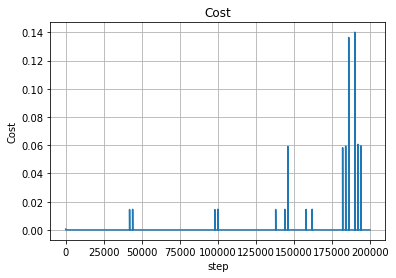

In [10]:
coststep = np.load("coststep.dat")
%matplotlib inline
import pandas as pd
ax = pd.Series(coststep).plot(title=r'Cost',grid=True)
ax.set_ylabel(r'Cost')
ax.set_xlabel('step')

# Trained NN
After trained NN, save weights and bias's as files:
"w1.dat, w2.dat, w3.dat, b1.dat, b2.dat, b3.dat"

We can load it directly so that we won't have to train this NN again when next time we open this file.

In [11]:
w1 = np.load("w1.dat").astype(float)
w2 = np.load("w2.dat").astype(float)
w3 = np.load("w3.dat").astype(float)
w4 = np.load("w4.dat").astype(float)
b1 = np.load("b1.dat").astype(float)
b2 = np.load("b2.dat").astype(float)
b3 = np.load("b3.dat").astype(float)
b4 = np.load("b4.dat").astype(float)

Define the trained NN as a function NN(x),
recall that we use our first 100th data in our dataset, 
we than test the NN with 101-1101 data.

In [12]:
def NN(x):
    L1 = tf.sigmoid(tf.matmul(x ,w1)+b1)
    L2 = tf.sigmoid(tf.matmul(L1,w2)+b2)
    L3 = tf.sigmoid(tf.matmul(L2,w3)+b3)
    L4 = tf.sigmoid(tf.matmul(L3,w4)+b4)
    y = tf.matmul(tf.transpose(L4),L4)
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        yo = sess.run(y)
    return yo
    
numm = 1000
for i in range(numm):
    pt = 0
    r = np.abs((NN(Xdata[100+i]) - Ydata[100+i])/Ydata[100+i])/numm
    pt += r
    
accuracy = ((1 - pt)*100).flatten()
print("Accuracy = ", accuracy[0], "%")
    
    

Accuracy =  99.99999999506551 %
